First load the necessary modules

In [1]:
import numpy as np
import scipy
import numdifftools
import astropy.table as atpy
import astropy.coordinates as acoord
import astropy.units as auni 
from math import pi
import healpy as hp
from healpy.newvisufunc import projview
import matplotlib.pyplot as plt
from velocity_field_fitting_codes import * # imports the two fitting functions

For this example, we will use the model from https://ui.adsabs.harvard.edu/abs/2024MNRAS.527..437V/abstract that best fits our data, i.e. L2M11. This is where you can switch into your own simulation to perform the fits on.

In [2]:
model = np.load('Vasiliev models/archive/L2M11/snapshot.npz')

#Extract all MW-relevant columns:
x = model['pos'][:, 0][int(2e6):int(9e6)]
y = model['pos'][:, 1][int(2e6):int(9e6)]
z = model['pos'][:, 2][int(2e6):int(9e6)]
vx = model['vel'][:, 0][int(2e6):int(9e6)]
vy = model['vel'][:, 1][int(2e6):int(9e6)]
vz = model['vel'][:, 2][int(2e6):int(9e6)]

# compute relevant parameters
R = np.sqrt(x**2 + y**2 + z**2)

C_Gal = acoord.SkyCoord(x = x * auni.kpc,
                        y = y * auni.kpc,
                        z = z * auni.kpc,
                        v_x = vx * auni.km / auni.s,
                        v_y = vy * auni.km / auni.s,
                        v_z = vz * auni.km / auni.s,
                        representation_type='cartesian',
                        frame = 'galactocentric')

C_helio = C_Gal.transform_to(acoord.Galactic)

l = np.array(C_helio.l)
b = np.array(C_helio.b)

VR = np.array(C_helio.radial_velocity)
def rv_to_gsr(c, v_sun=None):
    if v_sun is None:
        v_sun = acoord.Galactocentric().galcen_v_sun.to_cartesian()
    gal = c.transform_to(acoord.Galactic)
    cart_data = gal.data.to_cartesian()
    unit_vector = cart_data / cart_data.norm()
    v_proj = v_sun.dot(unit_vector)
    return c.radial_velocity + v_proj
V_GSR = np.array(rv_to_gsr(C_helio))

Now that our stellar particles are loaded, we need to apply the DESI footprint file to them, so that we only apply the fit of Eq. (10) to stars that fall within the DESI footprint. This is done using the file ```DESI_footprint.npy``` and the function ```apply_DESI_footprint```. All you need to perform this selection is the Galactic $(l, b)$ coordinates of your stellar particles.

In [3]:
def apply_DESI_footprint(l, b):
    """This function takes l, b values and checks which coordinates fall within the DESI footprint.
    It returns a boolean array that is used to mask away objects outside of this footprint."""
    
    # convert (l, b) from degrees to the colatitude/longitude convention used by healpy
    theta = np.radians(90. - b)  # colatitude
    phi   = np.radians(l)        # longitude
    
    # get the HEALPix pixel indices for each (l, b) point
    n_side = 2**5 # must be a base 2 power
    pix_idx = hp.ang2pix(n_side, theta, phi, nest=False)
    
    # now check which stars lie in pixels where mp_bool is True
    DESI_footprint = np.load('DESI_footprint.npy')
    in_DESI_footprint = DESI_footprint[pix_idx] # in_DESI_footprint is a boolean

    return in_DESI_footprint

in_DESI_footprint = apply_DESI_footprint(l, b)
distance_selection = (R>50) & (R<120) # to mimic the distance distribution of the BHB sample

selection = in_DESI_footprint & distance_selection

Let's visualise this footprint below. It will look similar to the grey regions in Fig. 5 in the paper, and shows the HEALPixels within which there are DESI bright and dark tiles.

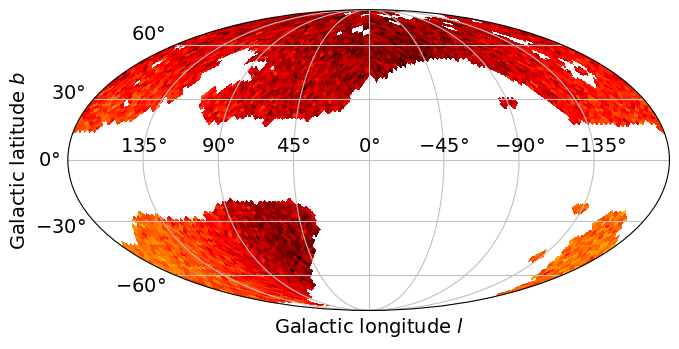

In [4]:
n_side = 2**5

def gen_fast_map(ip_):
    npixel  = hp.nside2npix(n_side)
    map_ = np.bincount(ip_, minlength=npixel)
    return map_

m = hp.ang2pix(n_side, l[selection], b[selection], lonlat=True)
mp = gen_fast_map(m)
fontsize = 14
sky = projview(mp,
        fontsize = {'xlabel':fontsize, 'ylabel':fontsize, 'xtick_label':fontsize, 'ytick_label':fontsize, 'cbar_label':fontsize, 'cbar_tick_label':fontsize},
        graticule=True,                  # turns on grid
        graticule_labels=True,           # turns on axis labels
        graticule_color = 'silver',      # grid colour
        cmap = plt.cm.hot_r,             # colormap
        cbar = False,                    # to not get colourbar
        xlabel="Galactic longitude $l$", # custom xlabel
        ylabel="Galactic latitude $b$",  # custom ylabel
        custom_xtick_labels=[r'$135\degree$', r'$90\degree$', r'$45\degree$', r'$0\degree$', r'$-45\degree$', r'$-90\degree$', r'$-135\degree$'],
        custom_ytick_labels=[r'$-60\degree$', r'$-30\degree$', r'$0\degree$', r'$30\degree$',  r'$60\degree$'],
        latitude_grid_spacing=30,        # gives 30 degrees latitude spacing
        longitude_grid_spacing=45,       # gives 45 degrees longitude spacing
        hold=True,                       # necessary to let matplotlib control figure size
        )
plt.show()

Now that we have selected the correct stellar particles, let's fit the halo velocity field given in Eq. (10), using maximum likelihood estimation. The minimisation code takes three inputs: the data, your initial guess, and bounds for the parameters. These are all given as tuples, with four elements for the data, and five for the initial guess and bounds (one for each model parameter, see Table 1).

In [5]:
data = (l[selection], # Galactic longitude
        b[selection], # Galactic latitude
        V_GSR[selection], # heliocentric radial velocity in the GSR frame
        np.zeros((selection).sum()) # the observational errors on radial velocity; for a simulation, this is an array of zeros
       ) 

# our initial guess is taken from Table 1
initial_guess = (-23.5, # v_compr
                 -34.0, # v_dipole
                 np.deg2rad(-72.7), # l_apex
                 np.deg2rad(-52.9), # b_apex
                 90.5 # sigma (the intrinsic dispersion)
                )

bounds = ((None, None), # v_compr 
          (None, None), # v_dipole 
          (None, None), # l_apex; going above |180| is allowed as that just corresponds to a rotation around the sphere
          (np.deg2rad(-90), np.deg2rad(90)), # b_apex; going above |90| degrees is unphysical due to geometry of the sphere
          (None, None) # sigma
         )

fit_result = loglikelihood_minimisation(data, initial_guess, bounds)
v_compr, v_apex, l_apex, b_apex, sigma, v_compr_error, v_apex_error, l_apex_error, b_apex_error, sigma_error = fit_result

print('v_compr =', round(v_compr, 1), '+-', round(v_compr_error, 1))
print('v_apex  =', round(v_apex, 1), '+-', round(v_apex_error, 1))
print('l_apex  =', round(l_apex, 1), '+-', round(l_apex_error, 1))
print('b_apex  =', round(b_apex, 1), '+-', round(b_apex_error, 1))
print('sigma   =', round(sigma, 1), '+-', round(sigma_error, 1))

v_compr = -11.2 +- 0.2
v_apex  = -40.5 +- 0.2
l_apex  = -25.3 +- 2.0
b_apex  = -78.9 +- 0.5
sigma   = 98.3 +- 0.1


$l_\mathrm{apex}$ is allowed to vary to suit whatever convention you use. In the paper, we choose $l ∈ [-180, 180]$, but you can rotate it by the appropriate amount of degrees based on your preference.

There are two things to be aware of. The first is that the code can give different numerical outputs depending on your initial guesses, and is especially sensitive to the input of $b_\mathrm{apex}$. However, because we are working with the sphere, different numerical outputs may still carry an identical physical meaning, e.g. you may notice $l_\mathrm{apex}$ being shifted by $360 ^\circ$ (which is an identical solution on the sphere), or that $v_\mathrm{apex}$ and $b_\mathrm{apex}$ are positive instead of negative, and that the apex direction has been shifted into the opposite hemisphere by 180 degrees (which is an identical solution to the dipole, since $v_\mathrm{compr}$ remains negative). However, it is important that the resulting $b_\mathrm{apex}$ is not exactly $-90^\circ$, which may also cause the error calculations to fail. If this happens, try a new initial guess.